<a href="https://colab.research.google.com/github/chan-kh/Music-Sentiment-Analysis/blob/main/LSTM_2outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
from google.colab import drive

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pandas import DataFrame

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Bidirectional

from math import sqrt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [2]:
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/features_60frames_allsongs.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,song_id,frame_num,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,valence,arousal
0,2,0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898,-0.073341,-0.109386
1,2,1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029,-0.074661,-0.114942
2,2,2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202,-0.074077,-0.116413
3,2,3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032,-0.078154,-0.118613
4,2,4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.

In [3]:
df =df.iloc[np.random.permutation(np.arange(104640).reshape(-1,60)).ravel()]

### With Normalization

In [4]:
df_train = df[:65880]
df_val = df[65880:73200]
df_test = df[73200:104640]

train_mean = df_train.mean()
train_std = df_train.std()

df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

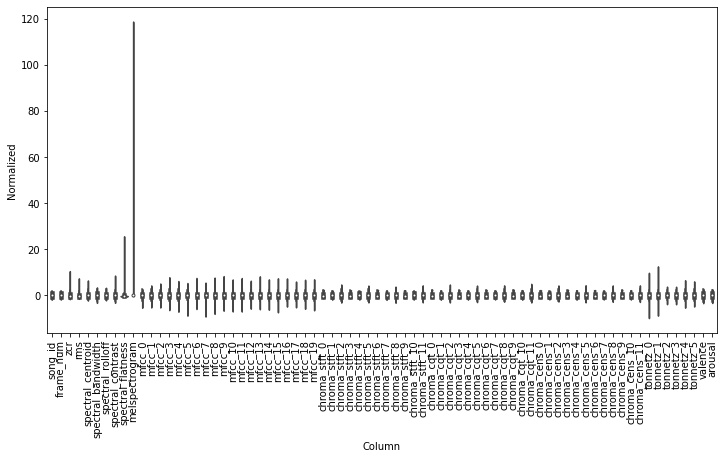

In [5]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [6]:
#With Normalization
y = df.loc[:,'valence':'arousal']
df_train.pop('song_id')
df_train.pop('frame_num')
df_train.pop('valence')
df_train.pop('arousal')

df_val.pop('song_id')
df_val.pop('frame_num')
df_val.pop('valence')
df_val.pop('arousal')

df_test.pop('song_id')
df_test.pop('frame_num')
df_test.pop('valence')
df_test.pop('arousal')


58080    0.533404
58081    0.519429
58082    0.522922
58083    0.480997
58084    0.477503
           ...   
9055    -0.576724
9056    -0.617639
9057    -0.669542
9058    -0.729307
9059    -0.724423
Name: arousal, Length: 31440, dtype: float64

In [7]:
train_X = df_train
train_X = train_X.to_numpy() 

val_X = df_val
val_X = val_X.to_numpy() 

test_X = df_test
test_X = test_X.to_numpy()

train_y = y[:65880]
train_y = train_y.to_numpy()

val_y = y[65880:73200]
val_y = val_y.to_numpy()

test_y = y[73200:104640]
test_y = test_y.to_numpy()

In [8]:
#With Normalization
train_X = train_X.reshape(1098,60,70)
train_y = train_y.reshape(1098,60,2)
val_X = val_X.reshape(122,60,70)
val_y = val_y.reshape(122,60,2)
test_X = test_X.reshape(524,60,70)
test_y = test_y.reshape(524,60,2)

### Without Normalization

In [9]:
# # Without Normalization
# df.pop('song_id')
# df.pop('frame_num')
# y = df.loc[:,'valence':'arousal']
# # print(y.shape)
# y.head()
# df.pop('valence')
# df.pop('arousal')
# features = df.to_numpy()
# y = y.to_numpy()
# # print(features.shape)
# # print(y.shape)

In [10]:
# # Without Normalization
# features = features.reshape(1744,60,70)
# y = y.reshape(1744,60,2)
# train_X , train_y = features[0:1098] , y[0:1098]
# val_X, val_y = features[1098:1220] , y[1098:1220]
# test_X , test_y = features[1220:1744] , y[1220:1744]
# print("train_X :" , train_X.shape , "train_y shape:" , train_y.shape)
# print("test_X :" , test_X.shape , "test_y shape:" , test_y.shape)
# print("val_X :" , val_X.shape , "val_y shape:" , val_y.shape)

### Experiment

In [11]:
train_loss = DataFrame()
val_loss = DataFrame()
train_accuracy = DataFrame()
val_accuracy = DataFrame()
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
for i in range(5):
  model = Sequential()
  model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
  model.add(Dropout(0.3))
  model.add(Dense(2))
  model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
  history = model.fit(train_X, train_y, epochs=500, validation_data=(val_X, val_y), verbose=2, shuffle=False)
  train_loss[str(i)] = history.history['loss']
  val_loss[str(i)] = history.history['val_loss']
  train_accuracy[str(i)] = history.history['accuracy']
  val_accuracy[str(i)] = history.history['val_accuracy']
  

# model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(16,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(8,return_sequences=True, input_shape=(60,70))))






Streaming output truncated to the last 5000 lines.
35/35 - 2s - loss: 0.0898 - accuracy: 0.5693 - val_loss: 0.0540 - val_accuracy: 0.5951
Epoch 2/500
35/35 - 1s - loss: 0.0530 - accuracy: 0.6172 - val_loss: 0.0512 - val_accuracy: 0.6199
Epoch 3/500
35/35 - 1s - loss: 0.0425 - accuracy: 0.6462 - val_loss: 0.0506 - val_accuracy: 0.6238
Epoch 4/500
35/35 - 1s - loss: 0.0378 - accuracy: 0.6636 - val_loss: 0.0502 - val_accuracy: 0.6206
Epoch 5/500
35/35 - 1s - loss: 0.0336 - accuracy: 0.6717 - val_loss: 0.0505 - val_accuracy: 0.6190
Epoch 6/500
35/35 - 1s - loss: 0.0300 - accuracy: 0.6858 - val_loss: 0.0515 - val_accuracy: 0.6230
Epoch 7/500
35/35 - 1s - loss: 0.0263 - accuracy: 0.6964 - val_loss: 0.0533 - val_accuracy: 0.6264
Epoch 8/500
35/35 - 1s - loss: 0.0231 - accuracy: 0.7138 - val_loss: 0.0569 - val_accuracy: 0.6264
Epoch 9/500
35/35 - 1s - loss: 0.0202 - accuracy: 0.7233 - val_loss: 0.0590 - val_accuracy: 0.6239
Epoch 10/500
35/35 - 1s - loss: 0.0179 - accuracy: 0.7362 - val_loss: 

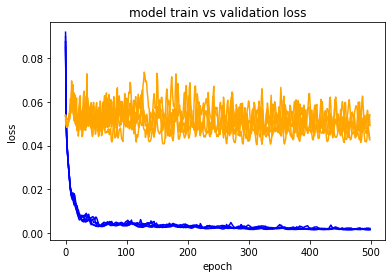

In [12]:
# plot train and validation loss across multiple runs
plt.plot(train_loss, color='blue', label='train')
plt.plot(val_loss, color='orange', label='validation')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

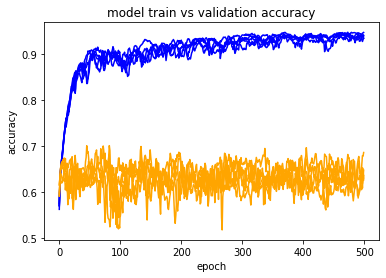

In [13]:
plt.plot(train_accuracy, color='blue', label='train')
plt.plot(val_accuracy, color='orange', label='validation')
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [14]:
# history = model.fit(train_X, train_y, epochs=300, validation_data=(val_X, val_y), verbose=2, shuffle=False)


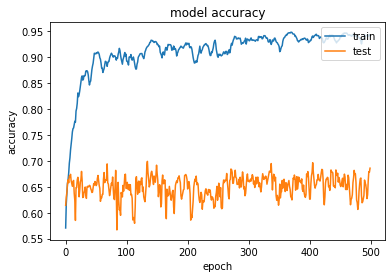

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

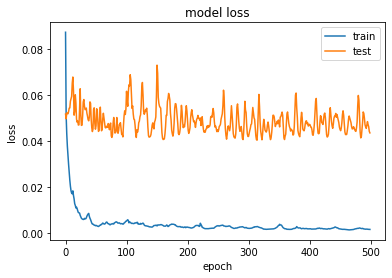

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [17]:
history.history
print('overall loss' , np.mean(history.history['loss']))
print('overall val_loss' , np.mean(history.history['val_loss']))

overall loss 0.0038703718616161496
overall val_loss 0.04884412991255522


In [18]:
predicted_y = model.predict(test_X)


In [19]:
print(predicted_y.shape)
print(test_y.shape)

(524, 60, 2)
(524, 60, 2)


In [20]:
predicted_valence = predicted_y[:,:,0]
predicted_arousal = predicted_y[:,:,1]
test_valence = test_y[:,:,0]
test_arousal = test_y[:,:,1]

In [21]:
# for i in range(1):
  # print(predicted_valence[i])
  # print(predicted_arousal[i])
  # print(test_valence[i])
  # print(test_arousal[i])

In [22]:
predicted_valence = predicted_valence.reshape(31440,)
test_valence = test_valence.reshape(31440,)
predicted_arousal = predicted_arousal.reshape(31440,)
test_arousal = test_arousal.reshape(31440,)

In [23]:
def metrics(y_true,y_pred,name):
  print(name,"")
  mae = mean_absolute_error(y_true,y_pred)
  rmse = sqrt(mean_squared_error(y_true,y_pred))
  r2 = r2_score(y_true,y_pred)
  pearson_corr = pearsonr(y_true,y_pred)
  spearman_corr = spearmanr(y_true,y_pred)
  
  print('RMSE : ',rmse)
  print('Pearson : ',pearson_corr)
  print('MAE : ',mae)
  print('R2 : ',r2)
  print('Spearman : ',spearman_corr,'\n')


In [24]:
def graph_results(x,y,title, xlim=-1, ylim=-1):
  #x and y are variables ( y_pred vs y_true )
  #Important
  plt.scatter(x,y,s=15)

  # if xlim != -1: plt.xlim([0, xlim])
  # if ylim != -1: plt.ylim([0, ylim])
  # plt.gca().set_ylim([1.5,7.5])
  # plt.gca().set_xlim([1.5,9])
  #Fix 
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title((title))
  # m, b = np.polyfit(x, y, 1)
  # plt.plot(x, m*x + b, color='red')  
  plt.savefig(title)

  plt.show()

valence 
RMSE :  0.2140569178342488
Pearson :  (0.4658589681818751, 0.0)
MAE :  0.17038530583973044
R2 :  0.1501882055864765
Spearman :  SpearmanrResult(correlation=0.4678797983292002, pvalue=0.0) 



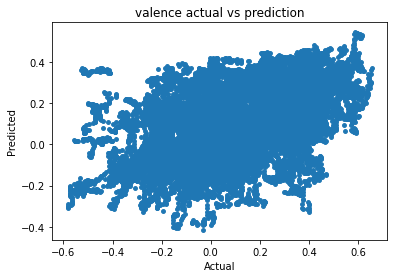

In [25]:
metrics(test_valence,predicted_valence,'valence')
graph_results(test_valence,predicted_valence,'valence actual vs prediction')


arousal 
RMSE :  0.18777043062184376
Pearson :  (0.7502572918164574, 0.0)
MAE :  0.14819852282658572
R2 :  0.5584136557413796
Spearman :  SpearmanrResult(correlation=0.7573989108758147, pvalue=0.0) 



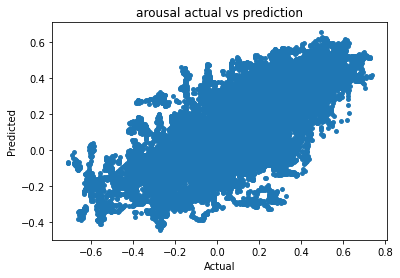

In [26]:
metrics(test_arousal,predicted_arousal,'arousal')
graph_results(test_arousal,predicted_arousal,'arousal actual vs prediction')